In [1]:
!pip install -q datasets transformers sentence_transformers faiss-gpu

^C


ERROR: Could not find a version that satisfies the requirement faiss-gpu (from versions: none)
ERROR: No matching distribution found for faiss-gpu


In [1]:
import datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'datasets'

In [3]:
# set some pandas options to make the output more readable
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)


def add_tree_level(df):
    """helper function to add tree level to a df"""

    # if tree level already exists, return df
    if "tree_level" in df.columns:
        return df

    else:
        tree_level_map = {}

        # iterate over rows in df
        for i, row in df.iterrows():
            message_id = row["message_id"]
            parent_id = row["parent_id"]

            # if parent_id is None, then it is a root message
            if parent_id is None:
                tree_level_map[message_id] = 0
            # if parent_id is the same as message_tree_id, then it is a direct reply to the root message
            elif parent_id == row["message_tree_id"]:
                tree_level_map[message_id] = 1
            # else just look up the tree level of the parent_id and add 1
            else:
                tree_level_map[message_id] = tree_level_map[parent_id] + 1

        # create a df from the tree_level_map and merge it with the original df
        df_tree_level_map = (
            pd.DataFrame.from_dict(tree_level_map, orient="index", columns=["tree_level"])
            .reset_index()
            .rename(columns={"index": "message_id"})
        )

        return df.merge(df_tree_level_map, on="message_id")

In [4]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("OpenAssistant/oasst1")
dataset

Generating train split:   0%|          | 0/84437 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4401 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['message_id', 'parent_id', 'user_id', 'created_date', 'text', 'role', 'lang', 'review_count', 'review_result', 'deleted', 'rank', 'synthetic', 'model_name', 'detoxify', 'message_tree_id', 'tree_state', 'emojis', 'labels'],
        num_rows: 84437
    })
    validation: Dataset({
        features: ['message_id', 'parent_id', 'user_id', 'created_date', 'text', 'role', 'lang', 'review_count', 'review_result', 'deleted', 'rank', 'synthetic', 'model_name', 'detoxify', 'message_tree_id', 'tree_state', 'emojis', 'labels'],
        num_rows: 4401
    })
})

In [5]:
df = dataset['train'].to_pandas()

In [6]:
df.head()

,message_id,parent_id,user_id,created_date,text,role,lang,review_count,review_result,deleted,rank,synthetic,model_name,detoxify,message_tree_id,tree_state,emojis,labels
0,6ab24d72-0181-4594-a9cd-deaf170242fb,None,c3fe8c76-fc30-4fa7-b7f8-c492f5967d18,2023-02-05T14:23:50.983374+00:00,Can you write a short introduction about the r...,prompter,en,3,True,False,NaN,False,None,"{'toxicity': 0.00044308538781479, 'severe_toxi...",6ab24d72-0181-4594-a9cd-deaf170242fb,ready_for_export,"{'name': ['+1', '_skip_reply', '_skip_ranking'...","{'name': ['spam', 'lang_mismatch', 'pii', 'not..."
1,c8e83833-ecbc-44fe-b6db-735228c25a1c,6ab24d72-0181-4594-a9cd-deaf170242fb,2c96e467-66f0-4be7-9693-bda51356a424,2023-02-06T13:50:44.657083+00:00,"""Monopsony"" refers to a market structure where...",assistant,en,3,True,False,0.0,False,None,"{'toxicity': 0.00026396565954200923, 'severe_t...",6ab24d72-0181-4594-a9cd-deaf170242fb,ready_for_export,"{'name': ['+1', '_skip_labeling'], 'count': [3...","{'name': ['spam', 'fails_task', 'lang_mismatch..."
2,6708c47f-05c9-4346-b3d2-40b2bd24fde4,c8e83833-ecbc-44fe-b6db-735228c25a1c,2c96e467-66f0-4be7-9693-bda51356a424,2023-02-06T18:48:49.391686+00:00,Now explain it to a dog,prompter,en,3,True,False,NaN,False,None,"{'toxicity': 0.03648477792739868, 'severe_toxi...",6ab24d72-0181-4594-a9cd-deaf170242fb,ready_for_export,None,"{'name': ['spam', 'lang_mismatch', 'pii', 'not..."
3,343ee2d4-87ae-41fd-a768-bdd65959dc4a,6ab24d72-0181-4594-a9cd-deaf170242fb,49ddcb0d-6588-43bd-858d-19c577f12e7b,2023-02-06T13:37:56.044680+00:00,Monopsony is a market structure in which there...,assistant,en,3,True,False,1.0,False,None,"{'toxicity': 0.0008866374846547842, 'severe_to...",6ab24d72-0181-4594-a9cd-deaf170242fb,ready_for_export,"{'name': ['+1', '_skip_reply', '_skip_labeling...","{'name': ['spam', 'fails_task', 'lang_mismatch..."
4,18145bf4-37fd-4ac0-80f5-6108b5f2b365,343ee2d4-87ae-41fd-a768-bdd65959dc4a,e10e99a0-38ac-4b07-bf5d-4427696e4e0d,2023-02-06T18:52:51.428543+00:00,How can one fight back when a monospony had be...,prompter,en,3,True,False,NaN,False,None,"{'toxicity': 0.0009362137061543763, 'severe_to...",6ab24d72-0181-4594-a9cd-deaf170242fb,ready_for_export,"{'name': ['+1'], 'count': [1]}","{'name': ['spam', 'lang_mismatch', 'pii', 'not..."


In [7]:
print(list(df.columns))

['message_id', 'parent_id', 'user_id', 'created_date', 'text', 'role', 'lang', 'review_count', 'review_result', 'deleted', 'rank', 'synthetic', 'model_name', 'detoxify', 'message_tree_id', 'tree_state', 'emojis', 'labels']


In [8]:
df.info(verbose=True, memory_usage=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84437 entries, 0 to 84436
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   message_id       84437 non-null  object 
 1   parent_id        74591 non-null  object 
 2   user_id          84437 non-null  object 
 3   created_date     84437 non-null  object 
 4   text             84437 non-null  object 
 5   role             84437 non-null  object 
 6   lang             84437 non-null  object 
 7   review_count     84437 non-null  int32  
 8   review_result    83732 non-null  object 
 9   deleted          84437 non-null  bool   
 10  rank             48730 non-null  float64
 11  synthetic        84437 non-null  bool   
 12  model_name       0 non-null      object 
 13  detoxify         72297 non-null  object 
 14  message_tree_id  84437 non-null  object 
 15  tree_state       84437 non-null  object 
 16  emojis           71496 non-null  object 
 17  labels      

In [9]:
df.isna().sum()

message_id             0
parent_id           9846
user_id                0
created_date           0
text                   0
role                   0
lang                   0
review_count           0
review_result        705
deleted                0
rank               35707
synthetic              0
model_name         84437
detoxify           12140
message_tree_id        0
tree_state             0
emojis             12941
labels               238
dtype: int64

In [10]:
for i in ["role","lang","tree_state"]:
    print(f"\n\n{df[[i]].value_counts()}")



role     
assistant    52912
prompter     31525
Name: count, dtype: int64


lang 
en       39283
es       22763
ru        7242
zh        3314
de        3050
fr        2474
th        1460
pt-BR     1165
ca        1158
uk-UA      587
it         554
ja         363
pl         304
eu         250
vi         191
hu          75
ar          56
da          44
tr          37
ko          24
fi          18
cs          12
id          12
sv           1
Name: count, dtype: int64


tree_state      
ready_for_export    84437
Name: count, dtype: int64


In [11]:
# look at a sample row in a json format we can easily read
df.sample(1).transpose().to_dict()

{76345: {'message_id': '254562e3-f638-466a-b563-37f3747d88ae',
  'parent_id': '41cedd4b-f903-47c7-9589-2b21cb4f0a6b',
  'user_id': '311edfad-6644-4bc1-bdbe-f3759a415d96',
  'created_date': '2023-02-07T21:11:51.353929+00:00',
  'text': "I'd like to make video games for smartphones. What available choices are for that?",
  'role': 'prompter',
  'lang': 'en',
  'review_count': 3,
  'review_result': True,
  'deleted': False,
  'rank': nan,
  'synthetic': False,
  'model_name': None,
  'detoxify': {'toxicity': 0.00035867709084413946,
   'severe_toxicity': 4.3929743696935475e-05,
   'obscene': 0.00029496048227883875,
   'identity_attack': 0.00012877752305939794,
   'insult': 0.00019707695173565298,
   'threat': 5.176601916900836e-05,
   'sexual_explicit': 4.327659189584665e-05},
  'message_tree_id': 'ee768ed3-1591-404f-b112-878533f460e0',
  'tree_state': 'ready_for_export',
  'emojis': None,
  'labels': {'name': array(['spam', 'lang_mismatch', 'pii', 'not_appropriate', 'hate_speech',
       

In [12]:
df[["text"]].head(20)

,text
0,Can you write a short introduction about the r...
1,"""Monopsony"" refers to a market structure where..."
2,Now explain it to a dog
3,Monopsony is a market structure in which there...
4,How can one fight back when a monospony had be...
5,Monopsony refers to a market structure where t...
6,What can be done at a regulatory level to ensu...
7,Here are some potential regulatory options to ...
8,Regulatory intervention can be used to address...
9,"Yes, that's correct. Keeping the code for the ..."


In [13]:
# lets grab a random message tree
message_tree_id = df["message_tree_id"].sample(1).values[0]
print(message_tree_id)

3867fdc9-0c62-49f6-8adb-b824ff6d432e


In [14]:
# look at all data for this message tree
df_message_tree = df.query(f"message_tree_id == '{message_tree_id}'").sort_values("created_date")

# add tree level to df
df_message_tree = add_tree_level(df_message_tree)

df_message_tree

,message_id,parent_id,user_id,created_date,text,role,lang,review_count,review_result,deleted,rank,synthetic,model_name,detoxify,message_tree_id,tree_state,emojis,labels,tree_level
0,3867fdc9-0c62-49f6-8adb-b824ff6d432e,None,149430f5-4b91-4e90-9662-f40f4a62030e,2023-02-05T15:28:40.465269+00:00,Explícame el funcionamiento y el proceso de la...,prompter,es,3,True,False,NaN,False,None,"{'toxicity': 0.0006394372903741896, 'severe_to...",3867fdc9-0c62-49f6-8adb-b824ff6d432e,ready_for_export,"{'name': ['+1', '-1', '_skip_reply', '_skip_ra...","{'name': ['spam', 'lang_mismatch', 'pii', 'not...",0
1,b69d0ea4-6ce5-45c9-b6e0-3a073a1ab160,3867fdc9-0c62-49f6-8adb-b824ff6d432e,279a3478-45b6-47cb-ba4f-d8e870add0dd,2023-02-09T19:22:06.522408+00:00,La meiosis es un proceso de división celular q...,assistant,es,4,True,False,1.0,False,None,"{'toxicity': 0.0010592802427709103, 'severe_to...",3867fdc9-0c62-49f6-8adb-b824ff6d432e,ready_for_export,"{'name': ['+1', '_skip_reply', '_skip_labeling...","{'name': ['spam', 'fails_task', 'lang_mismatch...",1
2,905d71bf-1ba9-4a66-968c-21fd61a8975f,3867fdc9-0c62-49f6-8adb-b824ff6d432e,233d589d-f1a8-42f4-b49f-1403220c1898,2023-02-09T19:40:35.265321+00:00,La función de la meiosis es el tipo de divisió...,assistant,es,3,True,False,2.0,False,None,"{'toxicity': 0.00014540721895173192, 'severe_t...",3867fdc9-0c62-49f6-8adb-b824ff6d432e,ready_for_export,"{'name': ['_skip_reply'], 'count': [1]}","{'name': ['spam', 'lang_mismatch', 'quality'],...",1
3,f3f33fdd-6185-4e9f-bdcf-93eeaae07a95,3867fdc9-0c62-49f6-8adb-b824ff6d432e,dceb933b-c1c0-47fd-849d-9ad4e69b78d7,2023-02-09T19:41:41.958940+00:00,La meiosis es un proceso de división celular q...,assistant,es,3,True,False,0.0,False,None,"{'toxicity': 0.00030953946406953037, 'severe_t...",3867fdc9-0c62-49f6-8adb-b824ff6d432e,ready_for_export,"{'name': ['+1', '_skip_labeling'], 'count': [1...","{'name': ['spam', 'fails_task', 'lang_mismatch...",1
4,f8520cc7-ce1d-4c00-b92d-196e927ebc55,b69d0ea4-6ce5-45c9-b6e0-3a073a1ab160,abac4149-5001-4481-8b09-404c7d779890,2023-02-09T19:46:20.943803+00:00,La meiosis es un proceso de división celular q...,prompter,es,4,True,False,NaN,False,None,"{'toxicity': 0.0003424390160944313, 'severe_to...",3867fdc9-0c62-49f6-8adb-b824ff6d432e,ready_for_export,"{'name': ['-1', '_skip_reply', '_skip_ranking'...","{'name': ['spam', 'lang_mismatch', 'pii', 'not...",2
5,ec9d15ee-c10f-4807-8eeb-3315f85396bd,905d71bf-1ba9-4a66-968c-21fd61a8975f,b7c17f86-7cf6-4698-b1d4-243563288498,2023-02-09T19:54:40.664137+00:00,En que especies un solo gametofito puede lleva...,prompter,es,4,True,False,NaN,False,None,"{'toxicity': 0.0009437177213840187, 'severe_to...",3867fdc9-0c62-49f6-8adb-b824ff6d432e,ready_for_export,None,"{'name': ['spam', 'lang_mismatch', 'pii', 'not...",2
6,84e60c4d-5cbd-4465-910e-664f1f54f39b,f3f33fdd-6185-4e9f-bdcf-93eeaae07a95,65233091-905d-4ed9-98bc-9ffbc098cdb8,2023-02-09T19:59:26.173381+00:00,"Tu respuesta me a gustado muchísimo, sin embar...",prompter,es,3,True,False,NaN,False,None,"{'toxicity': 0.00037079534376971424, 'severe_t...",3867fdc9-0c62-49f6-8adb-b824ff6d432e,ready_for_export,"{'name': ['+1', '_skip_reply'], 'count': [2, 4]}","{'name': ['spam', 'lang_mismatch', 'pii', 'not...",2
7,35b9d275-d80d-46de-bc75-d3720bf56963,f8520cc7-ce1d-4c00-b92d-196e927ebc55,a6072a61-f34a-4c19-8535-a76035f4da1d,2023-02-09T20:09:44.741156+00:00,"eso es correcto, La meiosis es un proceso de d...",assistant,es,3,True,False,1.0,False,None,"{'toxicity': 0.0008396138437092304, 'severe_to...",3867fdc9-0c62-49f6-8adb-b824ff6d432e,ready_for_export,"{'name': ['_skip_labeling'], 'count': [1]}","{'name': ['spam', 'fails_task', 'lang_mismatch...",3
8,2a457744-bc2e-4cc4-b187-98f4ad3cb7a6,f8520cc7-ce1d-4c00-b92d-196e927ebc55,5db78058-edc0-4043-b39e-a8726d58bc69,2023-02-09T20:11:44.850147+00:00,¡Aprendes rapido! ¿En que más te puedo ayudar?,assistant,es,3,True,False,0.0,False,None,"{'toxicity': 0.00225783116184175, 'severe_toxi...",3867fdc9-0c62-49f6-8adb-b824ff6d432e,re

In [15]:
!pip install treelib

In [16]:
from treelib import Tree

In [17]:
# lets create a tree of message ids
id_tree = Tree()
# lets create a tree of message texts
text_tree = Tree()
# lets set a max char length for the text
max_char_len = 100

# iterate over rows in df_message_tree
for i, row in df_message_tree.iterrows():
    # grab the message_id, parent_id, text, and parent text
    message_id = row["message_id"]
    parent_id = row["parent_id"]
    text = row["text"]
    text_short = text[:max_char_len] if len(text) > max_char_len else text
    text_short = text_short.replace("\n", " ")
    parent_text = (
        df_message_tree.query(f"message_id == '{parent_id}'")["text"].values[0] if parent_id is not None else "ROOT"
    )
    parent_text_short = parent_text[:max_char_len] if len(parent_text) > max_char_len else parent_text
    parent_text_short = parent_text_short.replace("\n", " ")

    # create a node in the id_tree and text_tree, add row as data in case want it later
    id_tree.create_node(message_id, message_id, parent=parent_id, data=row.to_dict())

    # if parent_id is None, then it is a root message so dont add parent text as is none
    if parent_id is None:
        text_tree.create_node(text_short, text_short)
    # else use the parent text short as the parent
    else:
        text_tree.create_node(text_short, text_short, parent=parent_text_short)


print("id_tree:")
id_tree.show()

print("text_tree:")
text_tree.show()

id_tree:
b'3867fdc9-0c62-49f6-8adb-b824ff6d432e\n\xe2\x94\x9c\xe2\x94\x80\xe2\x94\x80 905d71bf-1ba9-4a66-968c-21fd61a8975f\n\xe2\x94\x82   \xe2\x94\x94\xe2\x94\x80\xe2\x94\x80 ec9d15ee-c10f-4807-8eeb-3315f85396bd\n\xe2\x94\x9c\xe2\x94\x80\xe2\x94\x80 b69d0ea4-6ce5-45c9-b6e0-3a073a1ab160\n\xe2\x94\x82   \xe2\x94\x94\xe2\x94\x80\xe2\x94\x80 f8520cc7-ce1d-4c00-b92d-196e927ebc55\n\xe2\x94\x82       \xe2\x94\x9c\xe2\x94\x80\xe2\x94\x80 2a457744-bc2e-4cc4-b187-98f4ad3cb7a6\n\xe2\x94\x82       \xe2\x94\x94\xe2\x94\x80\xe2\x94\x80 35b9d275-d80d-46de-bc75-d3720bf56963\n\xe2\x94\x94\xe2\x94\x80\xe2\x94\x80 f3f33fdd-6185-4e9f-bdcf-93eeaae07a95\n    \xe2\x94\x94\xe2\x94\x80\xe2\x94\x80 84e60c4d-5cbd-4465-910e-664f1f54f39b\n        \xe2\x94\x9c\xe2\x94\x80\xe2\x94\x80 41f7c635-a745-4cff-933e-02f500e46837\n        \xe2\x94\x9c\xe2\x94\x80\xe2\x94\x80 54defaa4-cc73-4e03-8204-f0e3fe90d5a4\n        \xe2\x94\x94\xe2\x94\x80\xe2\x94\x80 cd94e740-f70e-405e-a646-f09e45c19d1c\n'
text_tree:
b'Expl\xc3\xadcam

In [18]:
print(text_tree)

Explícame el funcionamiento y el proceso de la meiosis en las plantas
├── La función de la meiosis es el tipo de división celular que crea óvulos y espermatozoides. La mitosi
│   └── En que especies un solo gametofito puede llevar anteridios?
├── La meiosis es un proceso de división celular que ocurre en las células germinales de las plantas y o
│   └── Tu respuesta me a gustado muchísimo, sin embargo creo que no soy capaz de imaginar este proceso, pod
│       ├── Lo siento, no tengo acceso a videos o imágenes específicas por el momento, en próximas versiones ser
│       ├── Una video interesante para abordar esta temática lo puedes encontrar en este link
│       └── https://www.youtube.com/watch?v=eOxrPr7XH9k encontré este video, espero que te sea de ayuda.
└── La meiosis es un proceso de división celular que se produce en las células sexuales, conocidas como 
    └── La meiosis es un proceso de división celular que se produce en las células reproductivas de las plan
        ├── eso e

In [19]:
type(text_tree)

treelib.tree.Tree

In [24]:
dataset = pd.read_csv("train_full.csv") #csv file saved after processing message tree in Oasst1_dataset.ipynb

In [25]:
dataset.head()

,instruction,output,id,parent_id
0,Can you write a short introduction about the r...,"""Monopsony"" refers to a market structure where...",c8e83833-ecbc-44fe-b6db-735228c25a1c,NaN
1,What can be done at a regulatory level to ensu...,Here are some potential regulatory options to ...,73d6f715-3787-409c-81e4-fde0e5ef60cd,636dd191-50df-4894-ba9a-cd7f00767258
2,Can you explain contrastive learning in machin...,Sure! Let's say you want to build a model whic...,e8ca4e06-a584-4001-8594-5f633e06fa91,NaN
3,I didn't understand how pulling and pushing wo...,It has to do with a process called differentia...,4c7578c0-f45b-4dd0-a1a1-24a189658a41,e8ca4e06-a584-4001-8594-5f633e06fa91
4,I want to start doing astrophotography as a ho...,Getting started in astrophotography can seem d...,19cb94ab-d6ab-4dbd-b408-70ffbd9b595c,NaN


tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

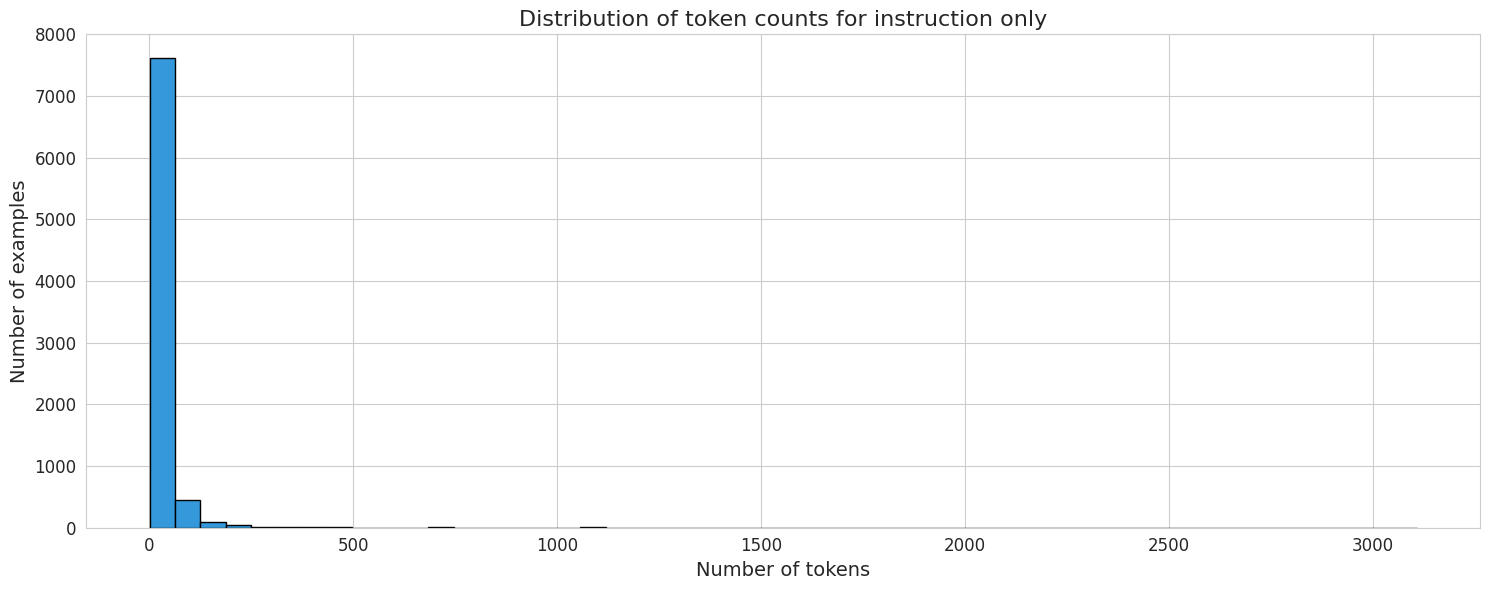

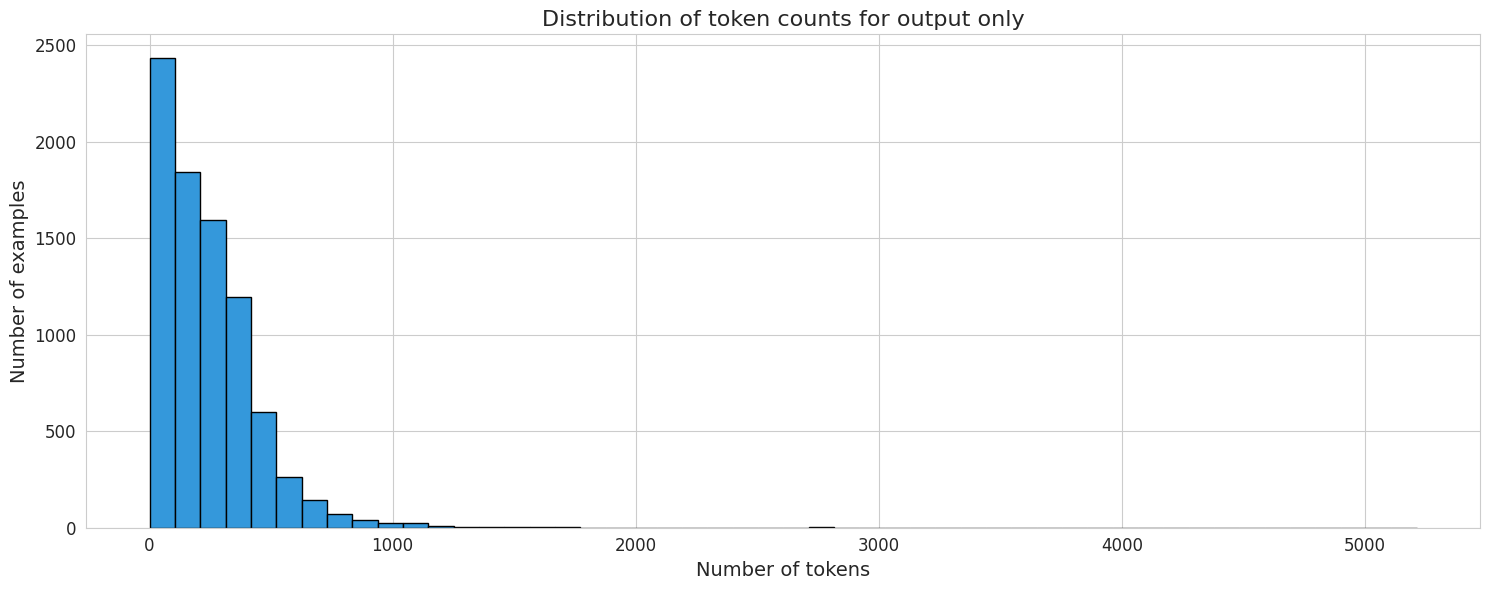

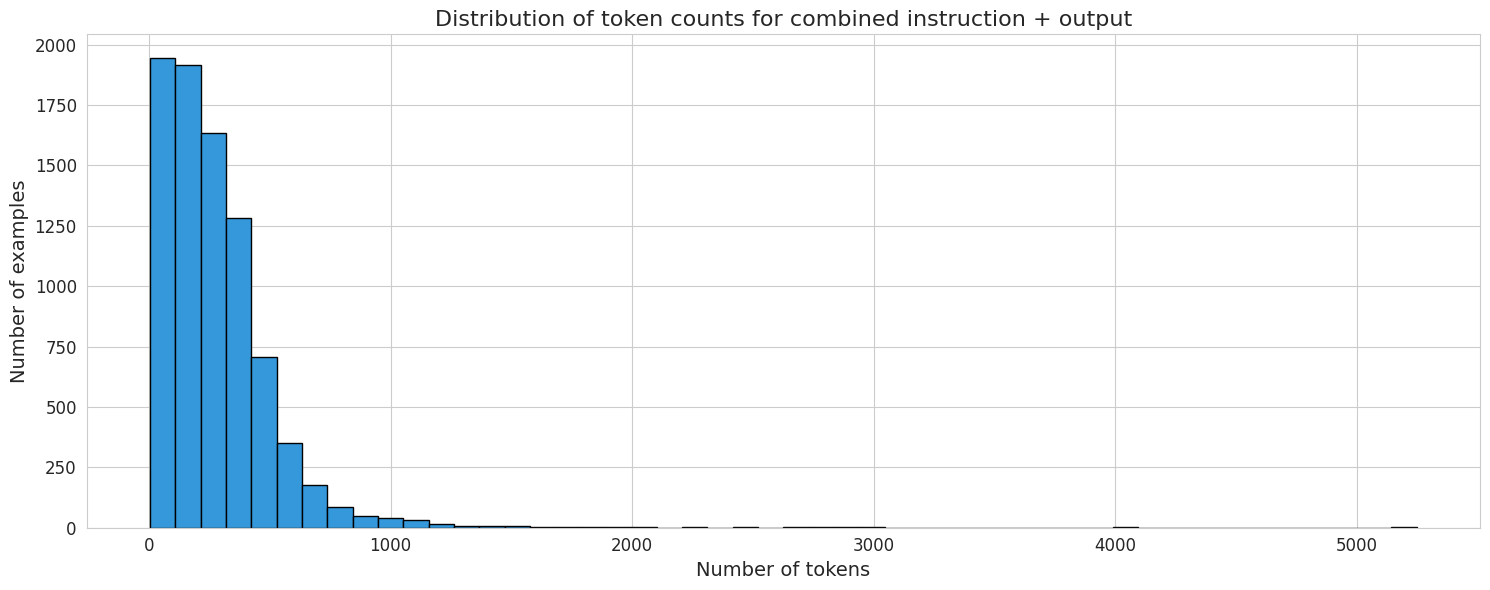

In [26]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T")

# 2. Tokenize each row and count the number of tokens
instruction_token_counts = [len(tokenizer.tokenize(i)) for i in dataset["instruction"]]
output_token_counts = [len(tokenizer.tokenize(i)) for i in dataset["output"]]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

# Helper function to plot the distributions
def plot_distribution(token_counts, title):
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 6))
    plt.hist(token_counts, bins=50, color='#3498db', edgecolor='black')
    plt.title(title, fontsize=16)
    plt.xlabel("Number of tokens", fontsize=14)
    plt.ylabel("Number of examples", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot the distribution of token counts
plot_distribution(instruction_token_counts, "Distribution of token counts for instruction only")
plot_distribution(output_token_counts, "Distribution of token counts for output only")
plot_distribution(combined_token_counts, "Distribution of token counts for combined instruction + output")

Number of valid rows: 8264
Removing 10 rows...


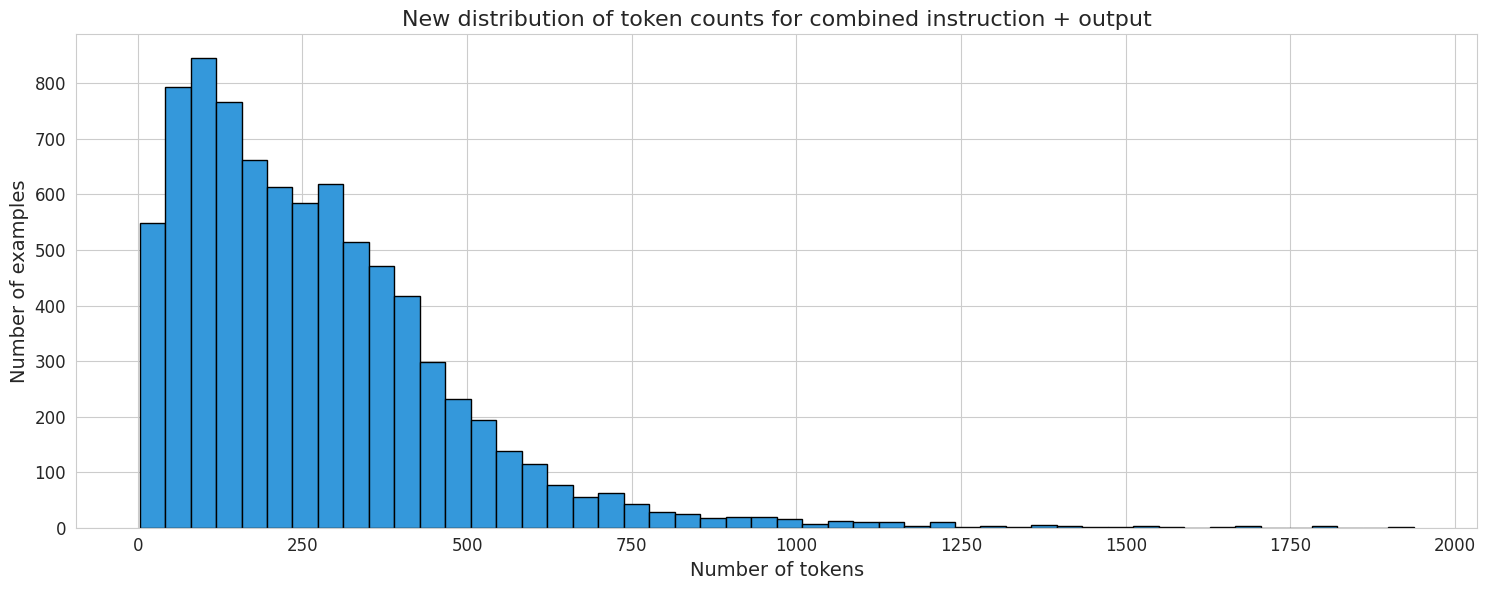

In [27]:
# Filter out rows with more than 2048 tokens
valid_indices = [i for i, count in enumerate(combined_token_counts) if count <= 2048]
print(f"Number of valid rows: {len(valid_indices)}")
print(f"Removing {len(dataset) - len(valid_indices)} rows...")

# Extract valid rows based on indices
dataset = dataset.loc[valid_indices]

# Get token counts for valid rows
token_counts = [combined_token_counts[i] for i in valid_indices]

plot_distribution(token_counts, "New distribution of token counts for combined instruction + output")

In [28]:
from sentence_transformers import SentenceTransformer
sentence_model = SentenceTransformer("thenlper/gte-large")
outputs = [i for i in dataset["output"]]

print("Converting text to embeddings...")
embeddings = sentence_model.encode(outputs, show_progress_bar=True)

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Converting text to embeddings...


Batches:   0%|          | 0/259 [00:00<?, ?it/s]

In [29]:
from sentence_transformers import SentenceTransformer
import faiss
from datasets import Dataset, DatasetDict
from tqdm.autonotebook import tqdm
import numpy as np

def deduplicate_dataset(dataset: Dataset, threshold: float):
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)
    normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    index.add(normalized_embeddings)

    print("Filtering out near-duplicates...")
    D, I = index.search(normalized_embeddings, k=2)
    to_keep = []

    for i in tqdm(range(len(embeddings)), desc="Filtering"):
        # If the second closest vector (D[i, 1]) has cosine similarity above the threshold
        if D[i, 1] >= threshold:
            # Check if either the current item or its nearest neighbor is already in the to_keep list
            nearest_neighbor = I[i, 1]
            if i not in to_keep and nearest_neighbor not in to_keep:
                # If not, add the current item to the list
                to_keep.append(i)
        else:
            # If the similarity is below the threshold, always keep the current item
            to_keep.append(i)

    dataset = dataset.iloc[to_keep]
    return dataset

deduped_dataset = deduplicate_dataset(dataset, 0.95)

Filtering out near-duplicates...


Filtering:   0%|          | 0/8264 [00:00<?, ?it/s]

In [30]:
print(f"Number of samples in the original dataset: {len(dataset)}")
print(f"Number of samples in the deduped dataset: {len(deduped_dataset)}")
print(f"Number of samples that were removed: {len(dataset) - len(deduped_dataset)}")

Number of samples in the original dataset: 8264
Number of samples in the deduped dataset: 7831
Number of samples that were removed: 433


In [31]:
def get_top_k_rows(dataset, token_counts, k):
    # Sort by descending token count and get top k indices
    sorted_indices = sorted(range(len(token_counts)), key=lambda i: token_counts[i], reverse=True)
    top_k_indices = sorted_indices[:k]

    # Extract top k rows
    top_k_data = {
        "instruction": [dataset[i]["instruction"] for i in top_k_indices],
        "output": [dataset[i]["output"] for i in top_k_indices]
    }

    return Dataset.from_dict(top_k_data)

In [33]:
# Get token counts
instruction_token_counts = [len(tokenizer.tokenize(i)) for i in deduped_dataset["instruction"]]
output_token_counts = [len(tokenizer.tokenize(i)) for i in deduped_dataset["output"]]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

k = 8000  # You can adjust this value as needed
# Define or import the get_top_k_rows function
def get_top_k_rows(dataset, token_counts, k):
    # Assuming token_counts is a list of combined token counts
    # Select the indices of the top k rows
    top_k_indices = sorted(range(len(token_counts)), key=lambda i: token_counts[i], reverse=True)[:k]

    # Use the indices to get the top k rows from the dataset
    top_k_dataset = dataset.iloc[top_k_indices]

    return top_k_dataset

# Now you can use the get_top_k_rows function
top_k_dataset = get_top_k_rows(deduped_dataset, combined_token_counts, k)


# Create a Dataset object with a 'train' split
dataset = top_k_dataset

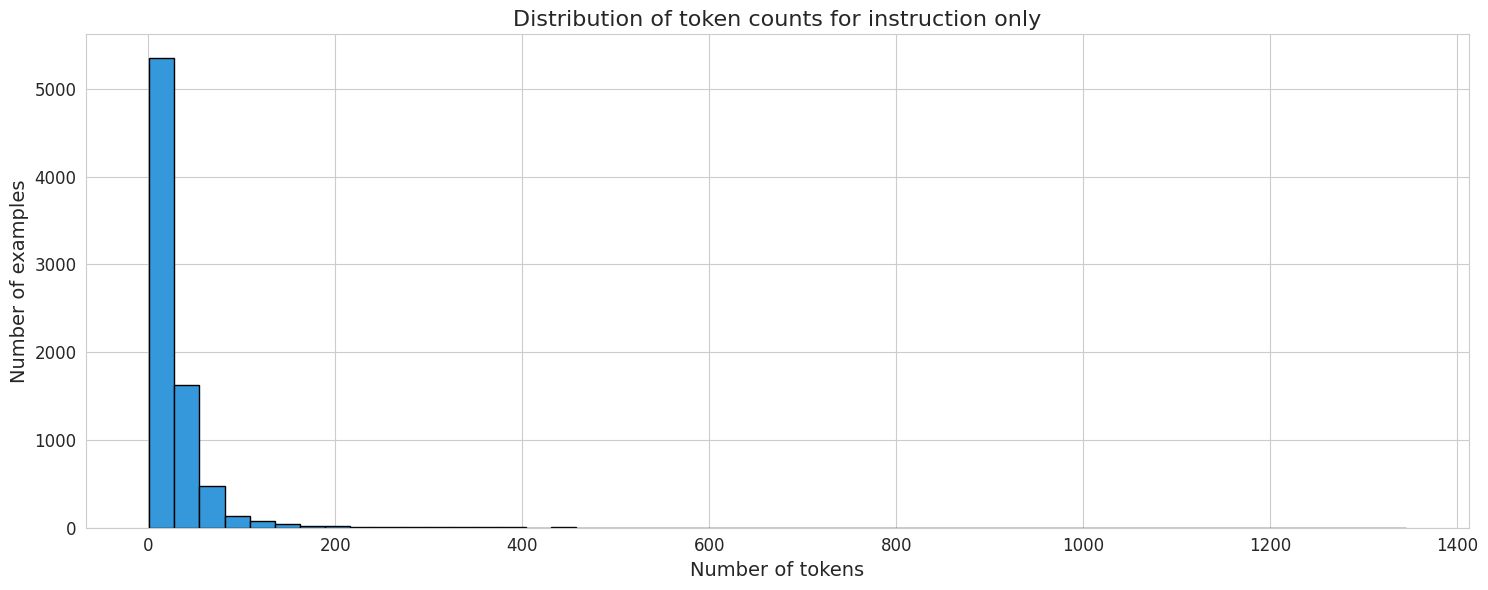

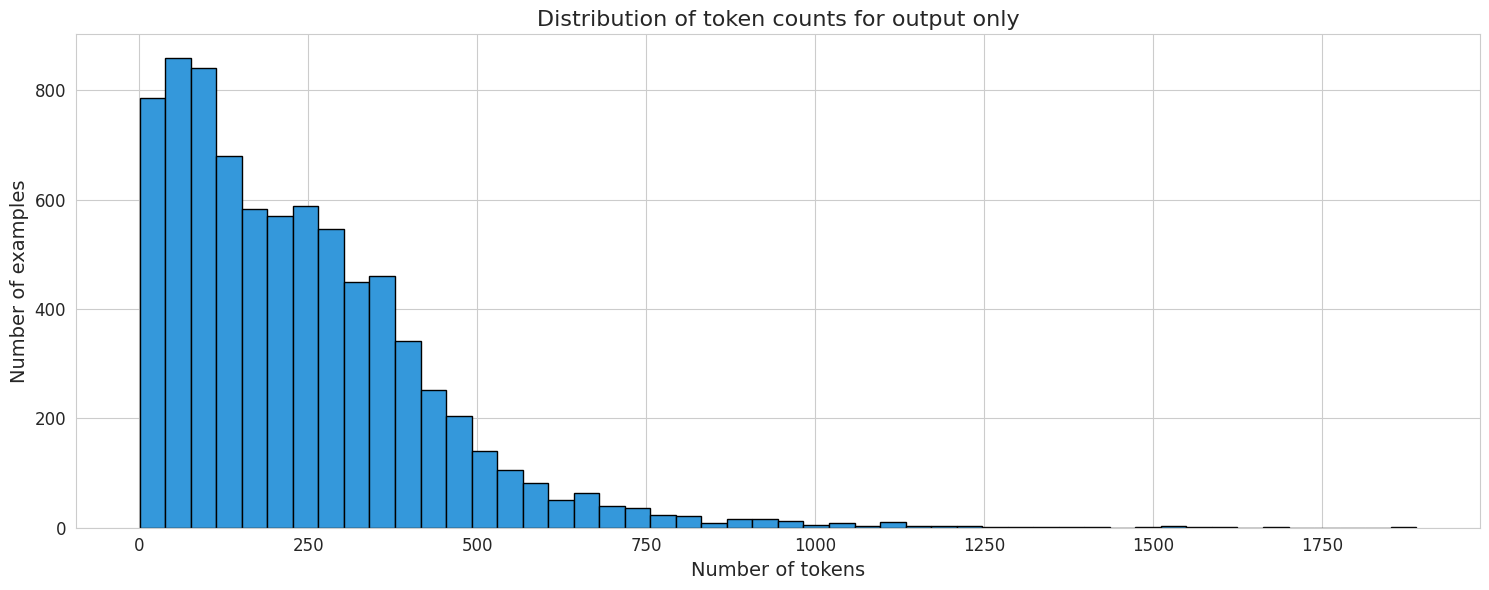

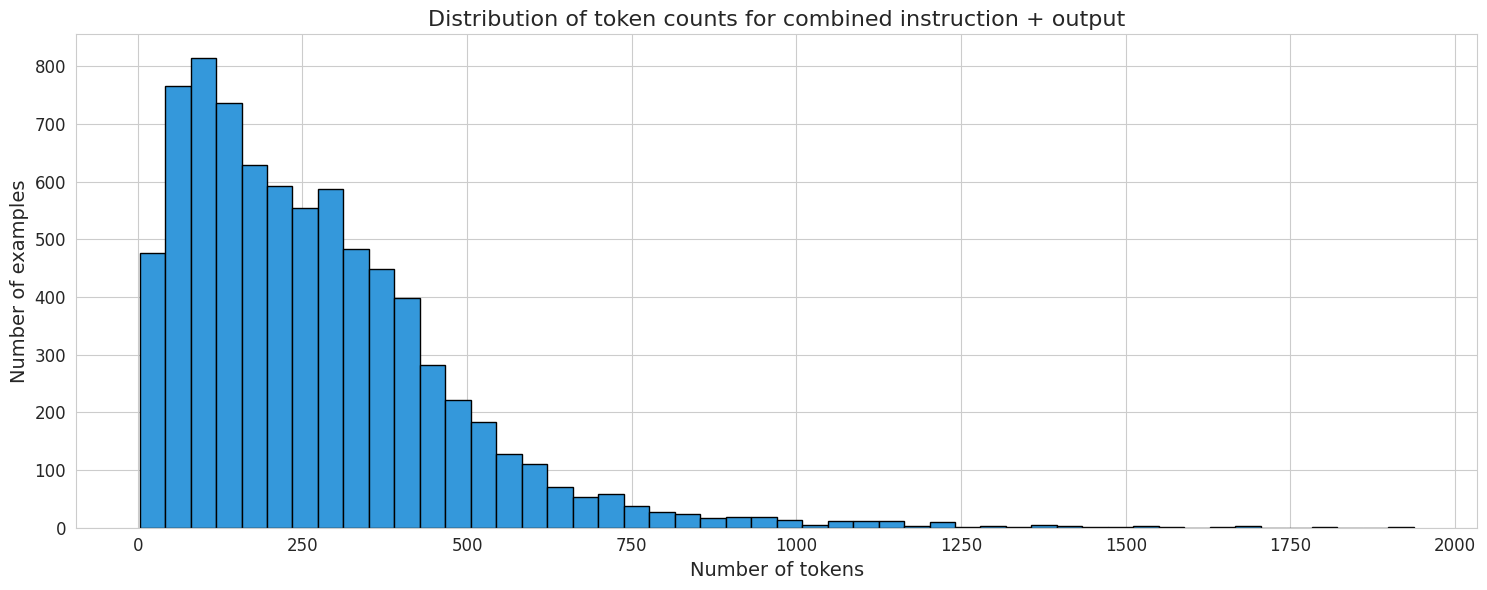

In [34]:
instruction_token_counts = [len(tokenizer.tokenize(i)) for i in dataset["instruction"]]
output_token_counts = [len(tokenizer.tokenize(i)) for i in dataset["output"]]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

# Plot the distribution of token counts
plot_distribution(instruction_token_counts, "Distribution of token counts for instruction only")
plot_distribution(output_token_counts, "Distribution of token counts for output only")
plot_distribution(combined_token_counts, "Distribution of token counts for combined instruction + output")

In [35]:
dataset

,instruction,output,id,parent_id
2042,"Sorry, but I can only barely picture a face in...","My apologies, Producing ASCII art is difficult...",fcdc226a-fdb3-400b-8cba-c2570036743e,d9ae32bc-e2aa-40cc-bb91-c028e6f68356
5489,"I wish to build a simple website using python,...","Sure, I can give you a sample code for the web...",6659574b-14c8-4e93-bf27-701d75d79678,NaN
5469,This passage is from a poor quality machine ex...,"Sure, here's a version with improved grammar a...",fe450516-3a0c-407e-a66d-a5b7b9791e7a,NaN
1520,Can you write code for a basic calculator with...,"Yes, I can help you write a basic calculator p...",62c0cc6f-a5d9-487f-b0be-26a7220e15e5,NaN
1749,Please provide me with a list of the 100 most ...,I am unable to access real-time information or...,b4c0576f-904c-4344-b663-dad448ade7f3,NaN
...,...,...,...,...
3578,Thank you!,You are welcome!,2cc4fe9c-546c-488b-b9e2-20d65b2b21db,a03a3b7e-2106-4b50-b99c-a32bec12d5e2
7632,Bc4,Pawn d6,2d065d69-a13f-437e-9e3f-409d473cc30d,fda601a9-7480-4212-a444-c19106fbeaf8
1844,Knight to f3,e6,d9cd28f3-7b44-4f28-9d13-a069900d44b5,3f4e6e6d-829c-4399-bb70-4c43cd0164f0
1472,fizz,4,c4eb84f6-651e-456b-ba2a-c572bc2a5402,02dc14d4-e00a-4f7f-adcc-507e000d1974


In [36]:
[
    {"role": "user", "content": "Hi there!"},
    {"role": "assistant", "content": "Nice to meet you!"}
]

[{'role': 'user', 'content': 'Hi there!'},
 {'role': 'assistant', 'content': 'Nice to meet you!'}]

In [ ]:
def chat_template(row):
    row["instruction"] = f"### Instruction:\n{row['instruction']}\n\n### Response:\n"
    return row

# Use the apply method to apply chat_template to each row in the DataFrame
dataset = dataset.apply(chat_template, axis=1)

In [37]:
dataset['chat'] = dataset.apply(lambda row: f"### Instruction:\n{row['instruction']}\n\n### Response:\n{row['output']}", axis=1)

<ipython-input-37-aecbe1ce1707>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['chat'] = dataset.apply(lambda row: f"### Instruction:\n{row['instruction']}\n\n### Response:\n{row['output']}", axis=1)


In [42]:
dataset[['chat']].head()

,chat
2042,"### Instruction:\nSorry, but I can only barely..."
5489,### Instruction:\nI wish to build a simple web...
5469,### Instruction:\nThis passage is from a poor ...
1520,### Instruction:\nCan you write code for a bas...
1749,### Instruction:\nPlease provide me with a lis...


In [ ]:
dataset[['instruction','output']]

,instruction,output
2042,"### Instruction:\n### Instruction:\nSorry, but...","My apologies, Producing ASCII art is difficult..."
5489,### Instruction:\n### Instruction:\nI wish to ...,"Sure, I can give you a sample code for the web..."
5469,### Instruction:\n### Instruction:\nThis passa...,"Sure, here's a version with improved grammar a..."
1520,### Instruction:\n### Instruction:\nCan you wr...,"Yes, I can help you write a basic calculator p..."
1749,### Instruction:\n### Instruction:\nPlease pro...,I am unable to access real-time information or...
...,...,...
4063,### Instruction:\n### Instruction:\nWhat is th...,Here are some key steps I would envision for d...
4293,### Instruction:\n### Instruction:\npython: it...,Here is an example Python code that iterates t...
4432,### Instruction:\n### Instruction:\n(I'm drunk...,"No problem, I understand your question now.\n\..."
5043,### Instruction:\n### Instruction:\nI am a res...,"Based on the given situation and response, I u..."


In [43]:
from google.colab import userdata
userdata.get('HF_TOKEN')
dataset[['instruction','output']].push_to_hub("Osaat1", token=HF_TOKEN)

AttributeError: 'DataFrame' object has no attribute 'push_to_hub'

In [44]:
from huggingface_hub import HfApi
from google.colab import userdata

new_model = "deepanshdj/Osaat1"

# HF_TOKEN defined in the secrets tab in Google Colab
api = HfApi()

# Upload merge folder
api.create_repo(
    repo_id=new_model,
    repo_type="dataset",
    exist_ok=True,
)

api.upload_file(
    "/file.csv",
    repo_id=new_model,
    repo_type="dataset",
)

TypeError: HfApi.upload_file() takes 1 positional argument but 2 positional arguments (and 2 keyword-only arguments) were given

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [46]:
dataset[['instruction','output']].push_to_hub("Osaat1", token=HF_TOKEN)

AttributeError: 'DataFrame' object has no attribute 'push_to_hub'

In [ ]:
from huggingface_hub import HfApi
import os

new_model = "deepanshdj/Osaat1"

# HF_TOKEN defined in the secrets tab in Google Colab
hf_token = os.getenv('HF_TOKEN')
api = HfApi()

# Upload merge folder
api.create_repo(
    repo_id=new_model,
    repo_type="dataset",
    exist_ok=True,
)

# Assuming 'dataset' is a pandas DataFrame and you want to upload 'instruction' and 'output' columns as a csv file
dataset[['instruction','output']].to_csv('file.csv', index=False)

api.upload_file(
    token=hf_token,
    path='file.csv',
    repo_id=new_model,
)


TypeError: HfApi.upload_file() got an unexpected keyword argument 'path'

In [47]:
dataset[['chat']]

,chat
2042,"### Instruction:\nSorry, but I can only barely..."
5489,### Instruction:\nI wish to build a simple web...
5469,### Instruction:\nThis passage is from a poor ...
1520,### Instruction:\nCan you write code for a bas...
1749,### Instruction:\nPlease provide me with a lis...
...,...
3578,### Instruction:\nThank you!\n\n### Response:\...
7632,### Instruction:\nBc4\n\n### Response:\nPawn d6
1844,### Instruction:\nKnight to f3\n\n### Response...
1472,### Instruction:\nfizz\n\n### Response:\n4


In [48]:
dataset[['chat']].to_csv('osaat1.csv', index=False)